In [398]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Intuition behind Derivatives

In [399]:
def f(x):
    return 3*x**2 - 4*x + 5

In [400]:
f(3.0)


20.0

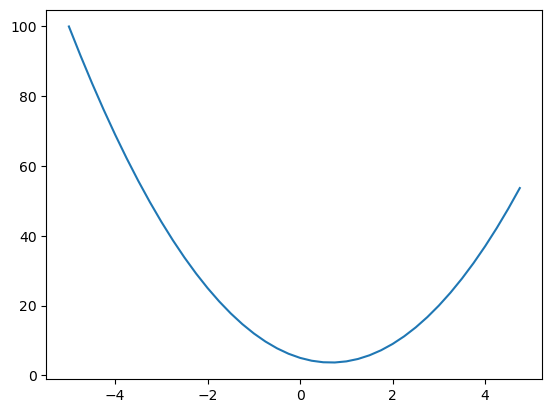

In [401]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)
plt.show()

## Differentiation for Univariate Functions

### Definition: *Derivative*

For $h \gt 0$ the *derivative* of $f$ at $x$ is defined as the limit

$$
\frac{df}{dx} := \lim_{h \to 0} \frac{ f(x + h) - f(x) }{ h }
$$


In [402]:
# For f(x) at x = 2/3:
h = 0.000001
x = 2/3
print((f(x + h) - f(x)) / h)

2.999378523327323e-06


## Partial Differentiation and Gradients

### Definition: *Partial Derivative*

For a function $f : \mathbb{R}^2 \to \mathbb{R}, \, \mathbf{x} \mapsto f(\mathbf{x}), \mathbf{x} \in \mathbb{R}^n$ of $n$ variables $x_1, \dots, x_n$ we define the *partial derivative* as 

$$
\frac{\partial f}{\partial x_1} = \lim_{h \to 0} \frac{ f(x_1 + h, x_2, \dots, x_n ) - f( \mathbf{x} ) }{ h }
$$
$$
\vdots
$$
$$
\frac{\partial f}{\partial x_n} = \lim_{h \to 0} \frac{ f(x_1, x_2, \dots, x_n + h ) - f( \mathbf{x} ) }{ h }
$$

and collect them in the new row vector

$$
\nabla_x f = \text{grad} f = \frac{\partial f}{\partial \mathbf{x}} =  \begin{bmatrix}
\frac{\partial f}{\partial x_1} & \frac{\partial f}{\partial x_2} & \dots & \frac{\partial f}{\partial x_n}
\end{bmatrix} \in \mathbb{R}^{1 \times n}
$$


In [403]:
# Multivariate function f(a, b, x) = a * b + c  

def f(a, b, c):
    return a*b + c

a = 2.0
b = -3.0
c = 10.0
d = f(a, b, c)
print(d)

4.0


In [404]:
# Partial derivatives for f with respect to a

h = 0.00001

# Inputs
a = 2.0
b = -3.0
c = 10.0

d1 = f(a, b, c)
d2 = f(a+h, b, c)

print("d1", d1)
print("d2", d2)
print("Derivative w. r. to a =", ((d2 - d1) / h))

d1 4.0
d2 3.9999699999999994
Derivative w. r. to a = -3.000000000064062


*The partial derivative with respect to $a$ of $f$ at $a=2, b=-3, c=10$ is -3.*

*Proving this with the analytical approach gives us $\frac{\partial f}{\partial a} = b$.*

In [405]:
# Partial derivatis for f with respect to b & c

h = 0.00001

# Inputs
a = 2.0
b = -3.0
c = 10.0

d3 = f(a, b+h, c)
d4 = f(a, b, c+h)

print("d3", d3)
print("Derivative w. r. to b =", ((d3 - d1) / h))
print("d3", d4)
print("Derivative w. r. to c =", ((d4 - d1) / h))

d3 4.00002
Derivative w. r. to b = 2.0000000000131024
d3 4.00001
Derivative w. r. to c = 0.9999999999621422


$$\frac{\partial f}{\partial b} = a$$

$$\frac{\partial f}{\partial c} = 1$$

# Neural Networks

In [406]:
class Value:

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"{self.label if self.label is not None else 'NoName'}: {self.data}"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __radd__(self, other):
        return self + other

    def __truediv__(self, other):
        return self * other**(-1)

    def __neg__(self):
        return self*(-1)

    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self,), f"**{other}")
        def _backward(): # f'(x^k) = k * x^(k-1)
            self.grad += out.grad * other * self.data**(other-1)
            pass
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), "exp")
        def _backward():
            self.grad += out.grad * out.data # f'(e(x)) = e(x)
        out._backward = _backward
        return out

    def tanh(self):
        t = (math.exp(2*self.data) - 1) / (math.exp(2*self.data) + 1)
        out = Value(t, (self, ), "tanh")
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for val in reversed(topo):
            val._backward()

    def copy(self):
        return Value(self.data, self._prev, self._op, self.label)


In [407]:
from graphviz import Digraph

def trace(root):
    nodes , edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }}" % (n.label, n.data, n.grad), shape="record")
        if n._op:
            dot.node(name = uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

## Manual Backpropagation for the Function

$$
L(a, b, c, d) = ((a \times b) + c) \times d
$$

Or

$$
L(a, b, c, d) = L(f(e(a, b), c), d), 
$$

with

$$
e(a, b) = a \times b, 
$$
$$
f(e, c) = e + c, 
$$
$$
L(f, d) = f \times d
$$

### Building the Computation Graph

In [408]:
# Input
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10, label="c")
d = Value(-2.0, label="d")

# Itermetiate nodes
e = a * b; e.label = "e"
f = e + c; f.label = "f"
L = f * d; L.label = "L"

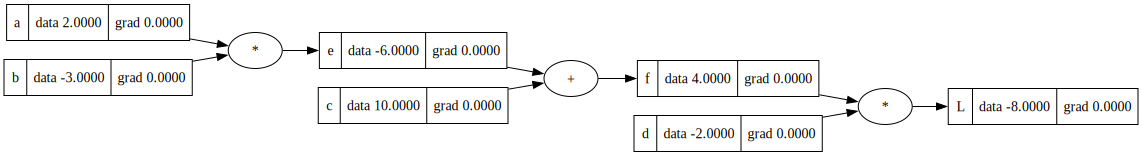

In [409]:
draw_dot(L)

### Backpropagation Step 1: **L**

The derivative of L with respect to L is 1.
$$ \frac{\partial L}{\partial L} = 1.0 $$
$$ \frac{\partial \text{ dependant var}\ }{\partial \text{ independant var}\ } = derivative $$

0.9999999999976694


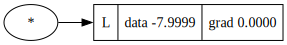

In [410]:
def partial_using_lim(dependent_var, independent_var, h=1e-4):
    list_of_values = [dependent_var.copy()]
    val1 = list_of_values[0].data

    def _copy_graph(current_value, independent_var, list_of_values):
        children = list(current_value._prev)
        if current_value.label == independent_var.label:
            current_value.data += h
            current_value._prev = set()
        elif len(children) == 1:
            new_children = [children[0].copy()]
            list_of_values.append(new_children[0])
            current_value._prev = set(new_children)
            list_of_values = _copy_graph(new_children[0], independent_var, list_of_values)
        elif len(children) > 1:
            order = [1, 0]
            if children[0]._prev == set():
                order = [0, 1]
            new_children = [children[order[i]].copy() for i in range(2)]
            list_of_values.append(new_children[0])
            list_of_values.append(new_children[1])
            current_value._prev = set(new_children)
            list_of_values = _copy_graph(new_children[0], independent_var, list_of_values)
            list_of_values = _copy_graph(new_children[1], independent_var, list_of_values)
        return list_of_values
    
    def _update_graph(value):
        if value._prev != set():
            children = list(value._prev)
            for child in children:
                _update_graph(child)
            if value._op == "*":
                value.data = children[0].data * children[1].data
            elif value._op == "+":
                value.data = children[0].data + children[1].data
            elif value._op == "tanh":
                value.data = (math.exp(2*children[0].data) - 1) / (math.exp(2*children[0].data) + 1)
    
    list_of_values = _copy_graph(list_of_values[0], independent_var, list_of_values)
    _update_graph(list_of_values[0])
    val2 = list_of_values[0].data

    return draw_dot(list_of_values[0]), ((val2 - val1) / h)

dot, derivative = partial_using_lim(L, L)
print(derivative)
dot


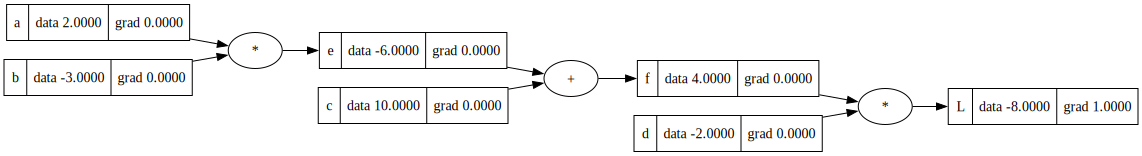

In [411]:
L.grad = 1.0
draw_dot(L)

### Backpropagation Step 2: **d** & **f**

Knowing that $L(f, d) = f \times d$, we can calculate the derivatives simply as

$$
\frac{ \partial L }{ \partial d} = f
$$

and 

$$
\frac{\partial L}{\partial f} = d
$$

3.9999999999995595


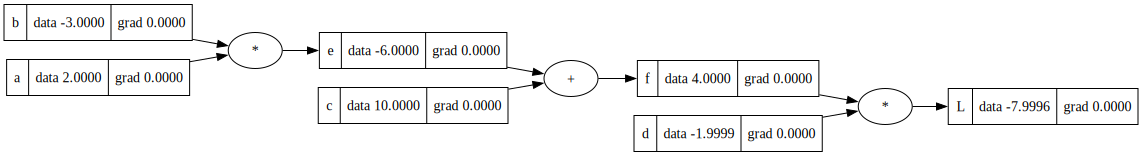

In [412]:
# For d:

dot, derivative = partial_using_lim(L, d)
print(derivative)
dot

-1.9999999999953388


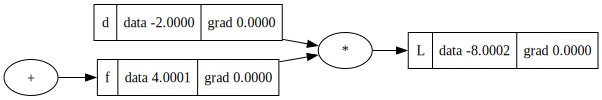

In [413]:
# For f:

dot, derivative = partial_using_lim(L, f)
print(derivative)
dot

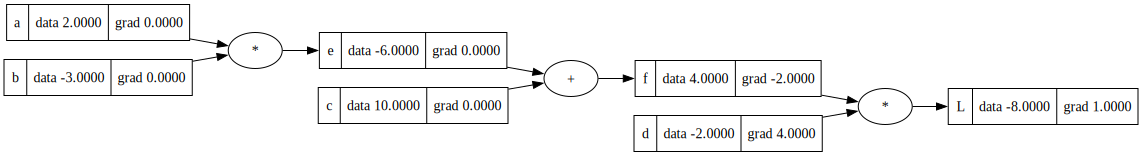

In [414]:
d.grad = f.data # = -2
f.grad = d.data # = 4
draw_dot(L)

### Backpropagation Step 3: **c** & **e**

In order to find the derivative $\frac{\partial L}{\partial e}$, we will first calculate the partial derivative $\frac{\partial f}{\partial e}$.

Since we know that $f(e, c) = e + c$, we can simply derive f as

$$\frac{\partial f}{\partial e} = 1$$

0.9999999999976694


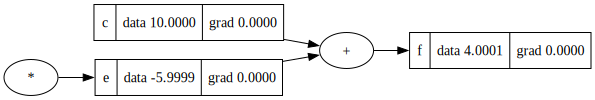

In [415]:
dot, derivative = partial_using_lim(f, e)
print(derivative)
dot

The same goes for $c$:
$$\frac{ \partial f }{ c } = 1$$

0.9999999999976694


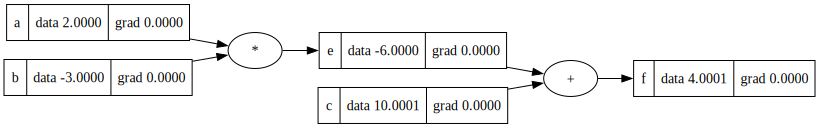

In [416]:
dot, derivative = partial_using_lim(f, c)
print(derivative)
dot

#### Chain Rule

$$\frac{\partial y}{\partial x} = \frac{\partial y}{\partial u} \frac{\partial u}{\partial x}$$


Therefore we can simply calculate $\frac{\partial L}{\partial c}$ and $\frac{\partial L}{\partial e}$ with the chain rule:

$$\frac{\partial L}{\partial c} = \frac{\partial L}{\partial f} \frac{\partial f}{\partial c} = -2 \times 1 = -2$$
$$\frac{\partial L}{\partial e} = \frac{\partial L}{\partial f} \frac{\partial f}{\partial e} = -2 \times 1 = -2$$




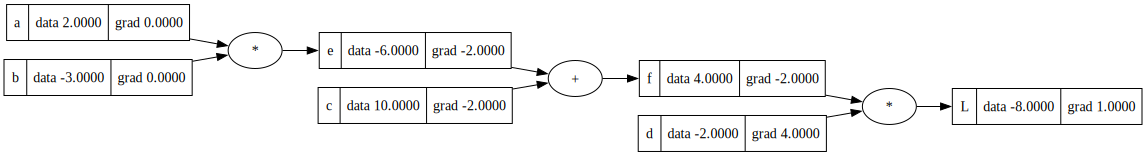

In [417]:
# Applying the gradients:
c.grad = e.grad = -2.0
draw_dot(L)

### Backpropagation Step 4: $a$ & $b$

We will again first calculate the partial derivatives $\frac{\partial e}{\partial a}$ and $\frac{\partial e}{\partial b}$.
Since we know that $e(a, b) = a \times b$, we can derive them manually again:

$$\frac{\partial e}{\partial a} = b = -3$$
$$\frac{\partial e}{\partial b} = a = 2$$



-3.000000000010772


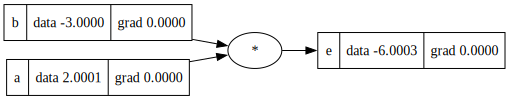

In [418]:
# For a
dot, derivative = partial_using_lim(e, a)
print(derivative)
dot

2.0000000000042206


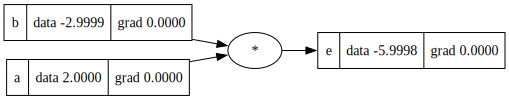

In [419]:
# for b
dot, derivative = partial_using_lim(e, b)
print(derivative)
dot

Calculating the gradient using the chain rule gives us:

$$\frac{\partial L}{\partial a} = \frac{\partial L}{\partial e} \frac{\partial e}{\partial a} = -2 \times -3 = 6$$
$$\frac{\partial L}{\partial b} = \frac{\partial L}{\partial e} \frac{\partial e}{\partial b} = -2 \times 2 = -4$$



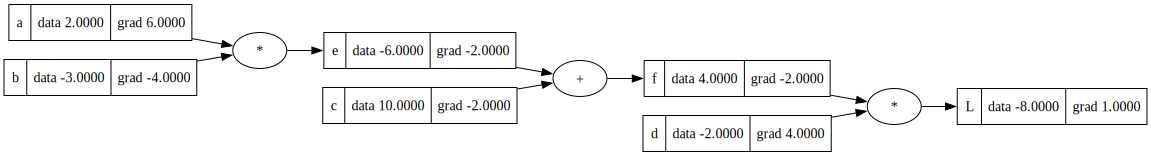

In [420]:
# Applying the gradients
a.grad = 6.0
b.grad = -4.0
draw_dot(L)

# Manual Backprop for a *Perceptron*

A perceptron is a simplified mathematical model of a biological neuron. It is defined as such:
$$perceptron(\mathbf{x}) = f(\mathbf{w}\mathbf{x} + b),$$
where
- $\mathbf{x}$ is the input vector
- $\mathbf{w}$ is the weight vector
- $b$ is the bias scalar
- $f(x)$ is the activation function

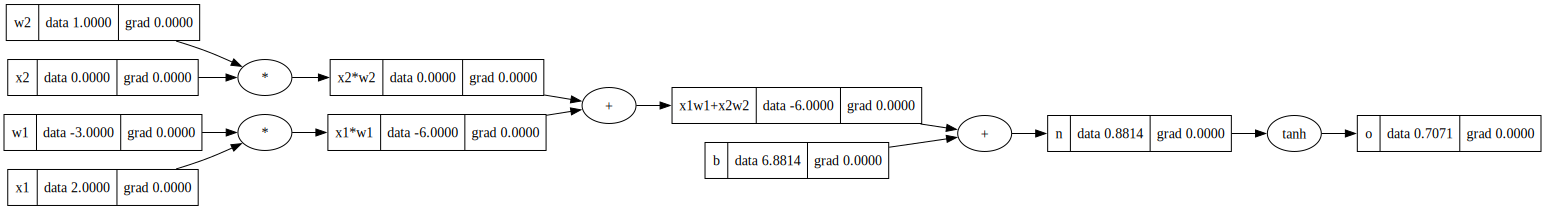

In [421]:
# Perceptron inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# Weights w1, w2, and bias b
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
b = Value(6.8813735870195432, label="b")
# n = x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1+x2w2"
n = x1w1x2w2 + b; n.label = "n"#
o = n.tanh(); o.label = "o"
draw_dot(o)

## Backpropagation Step 1: o

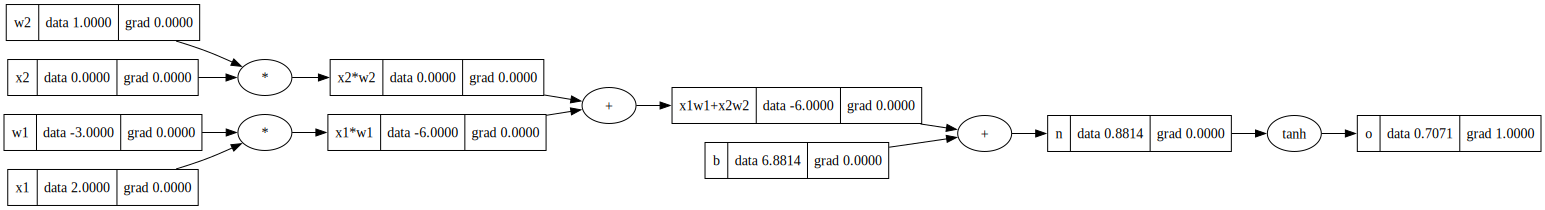

In [422]:
o.grad = 1
draw_dot(o)

## Backpropagation Step 2: n

We know that the derivative of $tanh(x)$ is equal to $1 - tanh^2(x)$. Therefor we can calculate

$$\frac{\partial o}{\partial n} = 1 - o^2 = 1 - 0.7071^2 = 0.5$$

0.4999646454939555


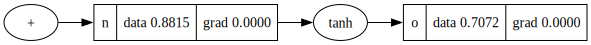

In [423]:
dot, derivative = partial_using_lim(o, n)
print(derivative)
dot

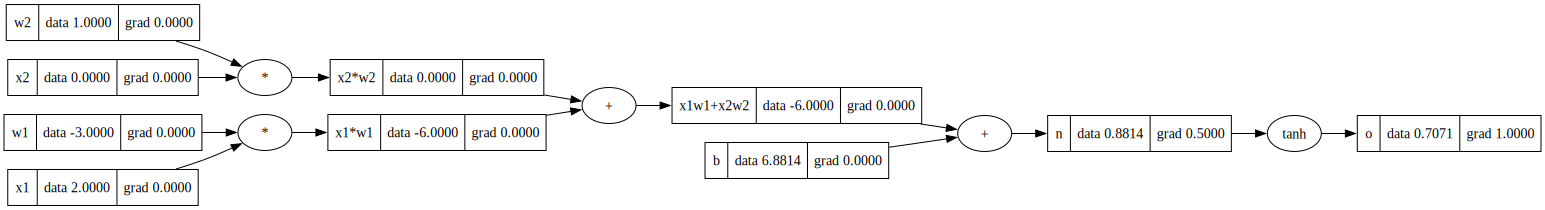

In [424]:
# Applying the gradient
n.grad = 0.5
draw_dot(o)

## Backpropagation Step 3: b & x2w1+x2w2

Since we have discovered that a plus operation simply distributes the gradient of the function it is embedded in, we can simply say:
$$\frac{\partial o}{\partial b} = \frac{\partial o}{\partial n} = 0.5$$
$$\frac{\partial o}{\partial x1w1+x2w2} = \frac{\partial o}{\partial n} = 0.5$$

In [425]:
dot, derivative = partial_using_lim(o, b)
print(derivative)

0.49996464549284525


In [426]:
dot, derivative = partial_using_lim(o, x1w1x2w2)
print(derivative)

0.49996464549284525


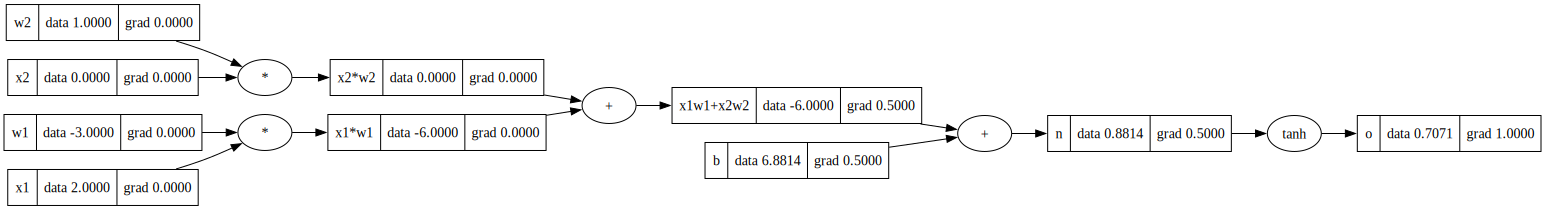

In [427]:
# Applying the gradients
b.grad = x1w1x2w2.grad = 0.5
draw_dot(o)

## Backpropagation Step 4: x1*w1 & x2*w2

The same goes for this operation:
$$\frac{\partial o}{\partial \text{x1*w1}} = \frac{\partial o}{\partial b} = \frac{\partial o}{\partial n} = 0.5$$
$$\frac{\partial o}{\partial \text{x2*w2}} = \frac{\partial o}{\partial \text{x1w1+x2w2}} = \frac{\partial o}{\partial n} = 0.5$$

In [428]:
dot, derivative = partial_using_lim(o, x1w1)
print(derivative)

0.49996464549284525


In [429]:
dot, derivative = partial_using_lim(o, x2w2)
print(derivative)

0.49996464549284525


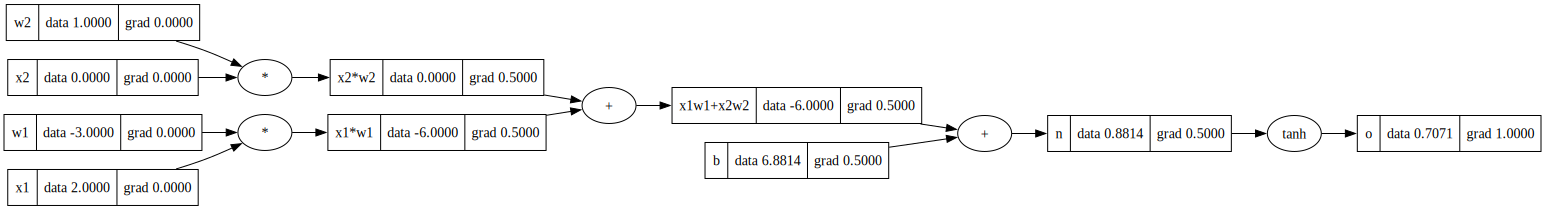

In [430]:
# Applying the gradients
x1w1.grad = x2w2.grad = 0.5
draw_dot(o)

## Backpropagation Step 5: x1 & w1

To find the derivative $\frac{\partial o}{\partial x1}$ and $\frac{\partial o}{\partial x2}$, we first need to find the partial derivatives of $\frac{\partial \text{x1*w1}}{\partial x1}$ and $\frac{\partial \text{x1*w1}}{\partial w1}$. //
We know that the derivative of a multiplication like $f(a, b) = a \times b$ with respect to $a$ is $b$. Therefor we can simply calculate the derivatives using the chain rule:
$$\frac{\partial o}{\partial x1} = \frac{\partial o}{\partial \text{x1*w1}} \frac{\partial \text{x1*w1}}{\partial x1} = 0.5 \times -3.0 = -1.5$$
$$\frac{\partial o}{\partial w1} = \frac{\partial o}{\partial \text{x1*w1}} \frac{\partial \text{x1*w1}}{\partial w1} = 0.5 \times 2.0 = 1.0$$


In [431]:
dot, derivative = partial_using_lim(o, x1)
print(derivative)

-1.500318220551966


In [432]:
dot, derivative = partial_using_lim(o, w1)
print(derivative)

0.9998585853132624


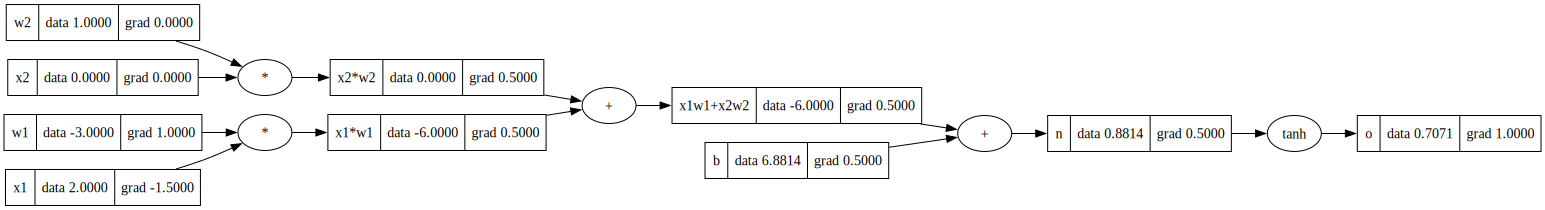

In [433]:
# Applying the gradients
x1.grad = -1.5
w1.grad = 1.0
draw_dot(o)

## Backpropagation Step 6: x2 and w2
Equivalent to *Step 5*.
$$\frac{\partial o}{\partial x2} = 0.5 \times 1.0 = 0.5$$
$$\frac{\partial o}{\partial w2} = 0.5 \times 0.0 = 0.0$$


In [434]:
dot, derivative = partial_using_lim(o, x2)
print(derivative)

0.49996464549284525


In [435]:
dot, derivative = partial_using_lim(o, w2)
print(derivative)

0.0


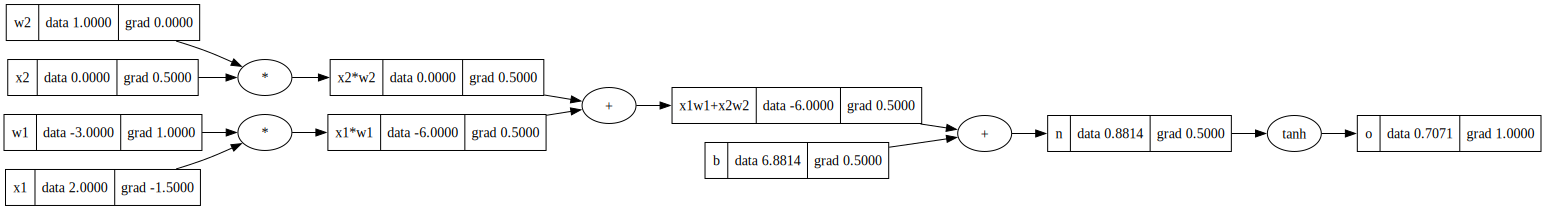

In [436]:
# Applying the gradients
x2.grad = 0.5
w2.grad = 0.0
draw_dot(o)

## Backprop with Autodifferentiation

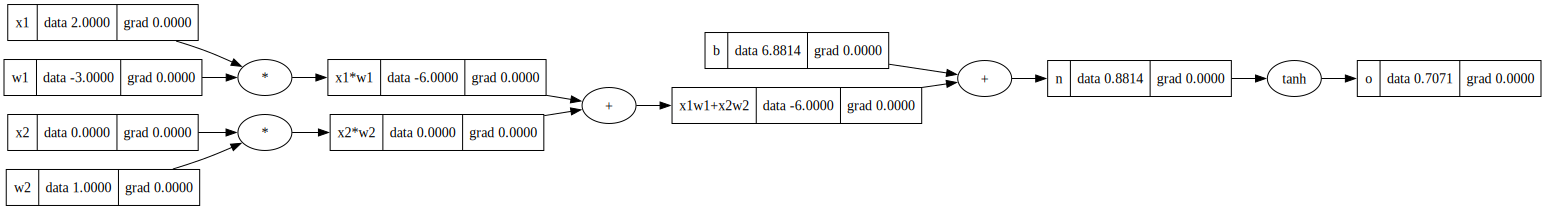

In [437]:
# Perceptron inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# Weights w1, w2, and bias b
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
b = Value(6.8813735870195432, label="b")
# n = x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1+x2w2"
n = x1w1x2w2 + b; n.label = "n"#
o = n.tanh(); o.label = "o"
draw_dot(o)

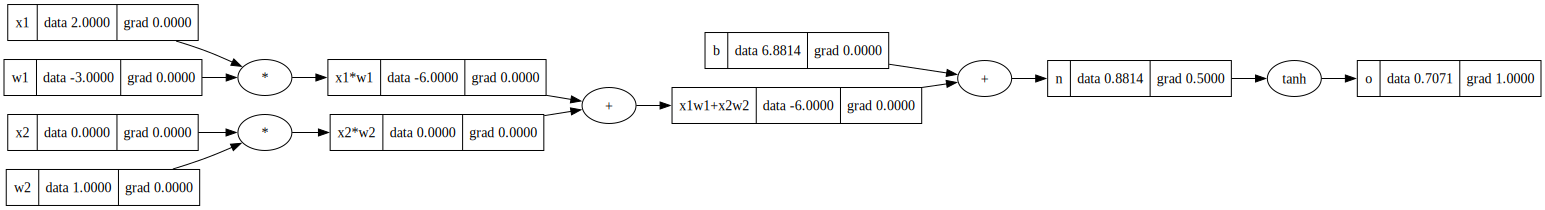

In [438]:
o.grad = 1.0
o._backward()
draw_dot(o)

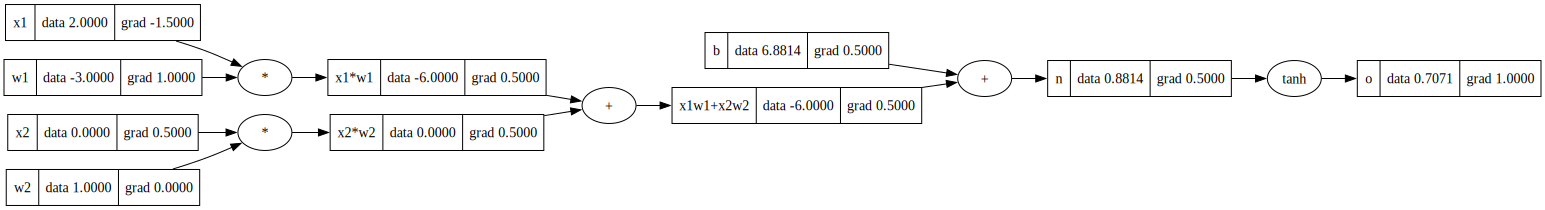

In [439]:
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
x1._backward()
w1._backward()
x2._backward()
w2._backward()
draw_dot(o)

## Doing the Same with Topologial Sort

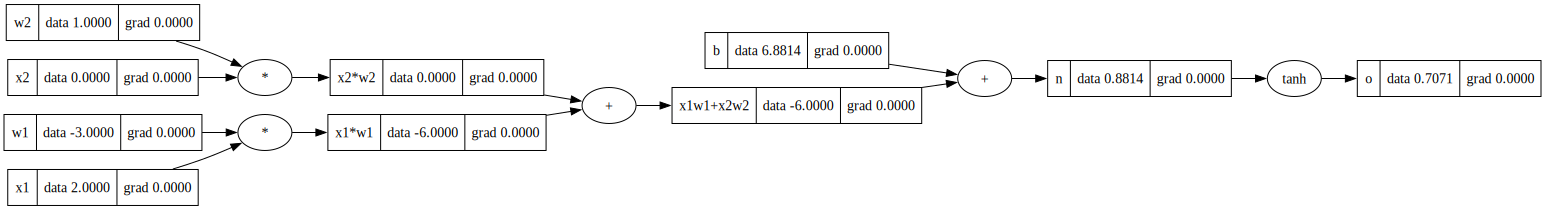

In [440]:
# Perceptron inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# Weights w1, w2, and bias b
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
b = Value(6.8813735870195432, label="b")
# n = x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1+x2w2"
n = x1w1x2w2 + b; n.label = "n"#
o = n.tanh(); o.label = "o"
draw_dot(o)

In [441]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[x2: 0.0,
 w2: 1.0,
 x2*w2: 0.0,
 x1: 2.0,
 w1: -3.0,
 x1*w1: -6.0,
 x1w1+x2w2: -6.0,
 b: 6.881373587019543,
 n: 0.8813735870195432,
 o: 0.7071067811865476]

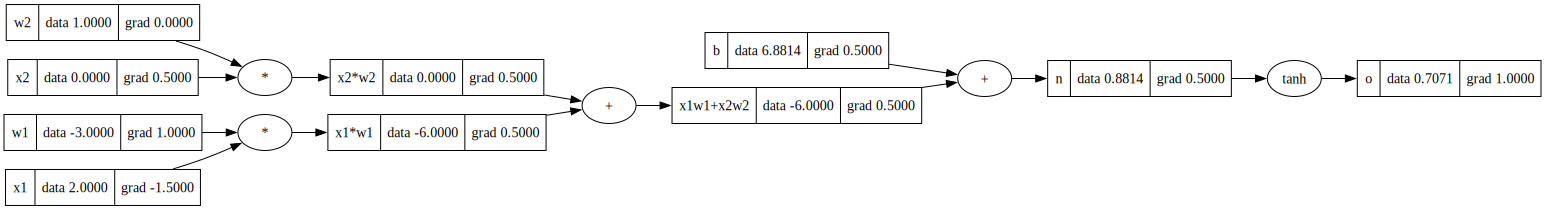

In [442]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

o.grad = 1.0
for val in reversed(topo):
    val._backward()
draw_dot(o)

## Using the *backward* Method of Value

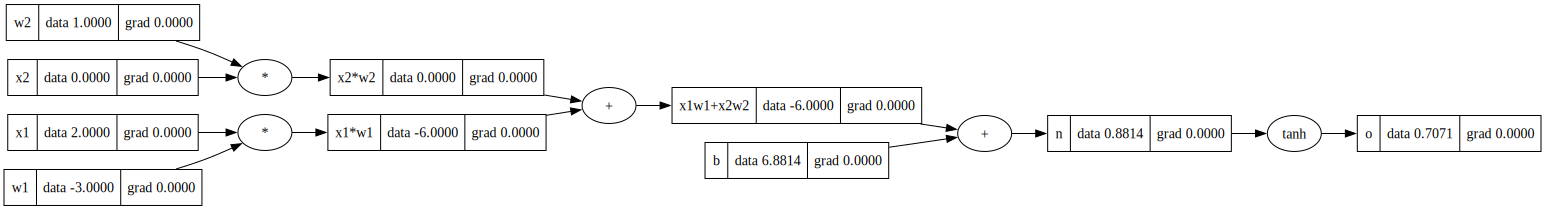

In [443]:
# Perceptron inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# Weights w1, w2, and bias b
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
b = Value(6.8813735870195432, label="b")
# n = x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1+x2w2"
n = x1w1x2w2 + b; n.label = "n"#
o = n.tanh(); o.label = "o"
draw_dot(o)

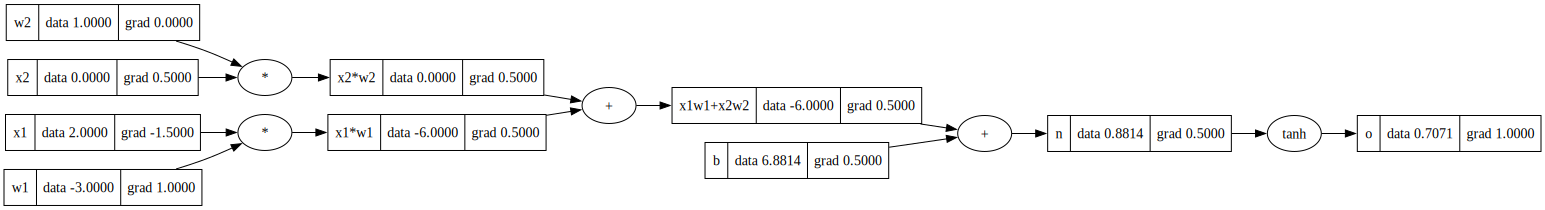

In [444]:
o.backward()
draw_dot(o)

## Fixing the Issue of cumulative gradients

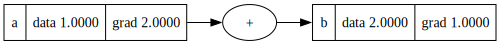

In [445]:
a = Value(1.0, label="a")
b = a + a; b.label = "b"
b.backward()
draw_dot(b)

## Changing the *tanh* implementation

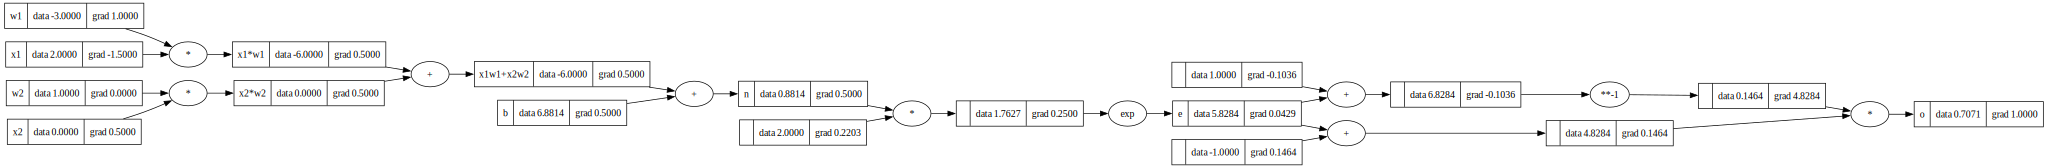

In [446]:
# Perceptron inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# Weights w1, w2, and bias b
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
b = Value(6.8813735870195432, label="b")
# n = x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1+x2w2"
n = x1w1x2w2 + b; n.label = "n"
#---------
e = (n*2).exp(); e.label = "e"
o = (e - 1) / (e + 1); o.label = "o"
#---------
o.backward()
draw_dot(o)

## Wrapping this in a Pytorch like API

In [447]:
class Neuron:

    def __init__(self, n_inputs):
        self.w = [Value(np.random.uniform(-1, 1)) for _ in range(n_inputs)]
        self.b = Value(np.random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        assert len(x) == len(self.w)#, f"Inputs 'x' must have be of length {len(self.)}."
        y = sum((x[i] * self.w[i] for i in range(len(self.w))), self.b)
        return y.tanh()

    def parameters(self):
        return self.w + [self.b]


class Layer:

    def __init__(self, n_inputs, n_outputs):
        self.n_inputs = n_inputs
        self.neurons = [Neuron(n_inputs) for _ in range(n_outputs)]

    def __call__(self, x):
        assert len(x) == self.n_inputs #, f"Inputs 'x' must be of length {self.n_inputs}."
        y = [neuron(x) for neuron in self.neurons]
        return y[0] if len(y) == 1 else y

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        params = []
        for neuron in self.neurons:
            params.extend(neuron.parameters())


class MLP:

    def __init__(self, n_inputs, n_outputs): # n_outputs: list of number of neurons per layer
        self.layers = []
        prev_layer_n_outputs = n_inputs
        for num_neurons in n_outputs:
            self.layers.append(Layer(prev_layer_n_outputs, num_neurons))
            prev_layer_n_outputs = num_neurons

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


## Backpropagating through the MLP

In [448]:
mlp = MLP(3, [4, 4, 1])
mlp.parameters()

[: 0.06373716676623542,
 : 0.3777853883377382,
 : 0.7366775109657211,
 : -0.040692052067912377,
 : -0.36477431201454724,
 : 0.5777949660315553,
 : 0.8537529649514717,
 : -0.5171326311184548,
 : -0.4109989477327092,
 : -0.6689549468056544,
 : -0.007094087970048291,
 : 0.9768858984797806,
 : -0.6960913062954333,
 : -0.7435662994397221,
 : 0.396763417455122,
 : 0.724245926212933,
 : 0.6348864822091085,
 : -0.17088498155183784,
 : 0.7516578707048869,
 : 0.6452764794813808,
 : 0.2601647826769682,
 : 0.4583620171785876,
 : -0.44150038575412087,
 : 0.11360533939696782,
 : 0.9469363881715014,
 : 0.43864964081346347,
 : 0.7961485615289117,
 : 0.8658847696798828,
 : 0.024512253164359787,
 : 0.22887850522095854,
 : -0.21077976628829065,
 : -0.7476449546487751,
 : 0.6842960695950375,
 : 0.560056577314014,
 : 0.4735029355464735,
 : -0.7545800242540104,
 : -0.2411975403922555,
 : -0.5949029287905141,
 : 0.3600816531950133,
 : 0.21745814933655572,
 : -0.6763898833226627]

In [449]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [1.0, 1.0, -1.0],
    [1.0, 0.5, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] # targets

y_pred = [mlp(x) for x in xs]
y_pred

[: -0.6221502770079331,
 : -0.9184753430824827,
 : -0.7728190745376897,
 : -0.8271096280070797]

In [450]:
# Mean squared error loss
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, y_pred)])
loss.backward()
loss

: 6.027958556532514

In [451]:
mlp.layers[0].neurons[0].w[0].data

0.06373716676623542

In [452]:
mlp.layers[0].neurons[0].w[0].grad

0.6467776325130308

In [453]:
learning_rate = 0.011

for p in mlp.parameters():
    p.data += -learning_rate * p.grad

mlp.layers[0].neurons[0].w[0].data

0.056622612808592085

In [454]:
class LossFunction:
    """ Loss Function Interface """
    @staticmethod
    def __call__(y_pred, y)-> Value:
        pass


class MeanSquaredError(LossFunction):
    """ Mean Squared Error implementation of LossFunction """
    @staticmethod
    def __call__(y_pred, y):
        return sum((y_out - y_true)**2 for y_out, y_true in zip(y_pred, y))


class Optimizer:
    def __init__(self, model:MLP, loss_fct:LossFunction=lambda y_pred, y: sum((y_out - y_true)**2 for y_out, y_true in zip(y_pred, y))):
        self.model = model
        self.loss_fct = loss_fct

    def _step(self, X, y, learning_rate):
        # Forward pass
        y_pred = [self.model(x) for x in X]
        loss = self.loss_fct(y_pred, y)

        # Backward pass
        loss.backward()
        for p in self.model.parameters():
            p.data -= learning_rate * p.grad
        return loss

    def fit(self, X, y, epochs, learning_rate=1e-3):
        # Parameter check
        assert len(X[0]) == self.model.layers[0].n_inputs, "Input X has wrong shape"
        assert len(y) == self.model.layers[-1].n_inputs, "Input y has wrong shape"

        history = []
        for _ in range(epochs):
            history.append(self._step(X, y, learning_rate))
        return history

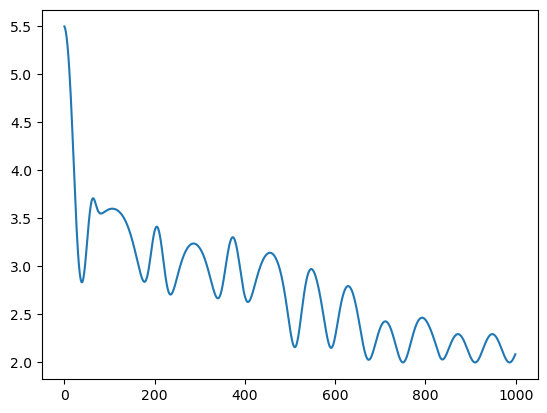

In [455]:
optimizer = Optimizer(mlp)
history = optimizer.fit(xs, ys, epochs=1000, learning_rate=0.0001)
plt.plot([val.data for val in history])
plt.show()

In [456]:
history

[: 5.492965239413536,
 : 5.481944303954349,
 : 5.465000421007442,
 : 5.442076037580787,
 : 5.413097862016338,
 : 5.3779813669151375,
 : 5.336636818804456,
 : 5.288977043431089,
 : 5.234927122713652,
 : 5.174436160769732,
 : 5.1074911346432845,
 : 5.034132643093333,
 : 4.954472072227068,
 : 4.868709312024881,
 : 4.777149710271584,
 : 4.68021850393737,
 : 4.578470628852848,
 : 4.472593717336933,
 : 4.363402395926032,
 : 4.251822788624584,
 : 4.138867397839004,
 : 4.025602093844372,
 : 3.9131084523037116,
 : 3.8024457176794657,
 : 3.6946168863034203,
 : 3.5905426639783364,
 : 3.491045522549673,
 : 3.396844168272029,
 : 3.3085569447638274,
 : 3.226711437624728,
 : 3.1517570263056336,
 : 3.0840773092739537,
 : 3.0240000140269085,
 : 2.971802935091397,
 : 2.927715386848712,
 : 2.8919154519614656,
 : 2.8645238691324453,
 : 2.845595720504849,
 : 2.8351111771762127,
 : 2.832966491803581,
 : 2.8389662484197844,
 : 2.852817646794318,
 : 2.874127357615019,
 : 2.902401266993072,
 : 2.93704724992811

In [457]:
# loop

epochs = 100
learning_rate = 0.0001

for epoch in range(epochs):
    # Forward pass
    y_pred = [mlp(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, y_pred)])
    print(loss)
    # Backward pass
    loss.backward()
    for p in mlp.parameters():
        p.data += -learning_rate * p.grad

: 2.096672631999963
: 2.1085919870805148
: 2.12071308423593
: 2.1329443391162
: 2.1451967307771547
: 2.157384461015907
: 2.1694254940547064
: 2.1812419809788253
: 2.192760576107214
: 2.2039126545683523
: 2.21463444180263
: 2.2248670665772385
: 2.234556549456591
: 2.2436537386071906
: 2.2521142044167988
: 2.259898103757613
: 2.266970023896781
: 2.2732988151206834
: 2.2788574201455623
: 2.2836227073793283
: 2.287575314108666
: 2.2906995047335346
: 2.2929830482701163
: 2.294417118497951
: 2.2949962193359936
: 2.29471813728909
: 2.293583922100811
: 2.2915978960675805
: 2.2887676917984203
: 2.28510431752892
: 2.2806222484026355
: 2.2753395414043993
: 2.2692779708565376
: 2.2624631805630626
: 2.25492484780496
: 2.2466968534541523
: 2.2378174514941724
: 2.2283294302301226
: 2.218280256466605
: 2.2077221929689346
: 2.1967123786495786
: 2.18531286020026
: 2.17359056339223
: 2.1616171920739484
: 2.1494690430928105
: 2.1372267260428988
: 2.1249747779747494
: 2.112801165063738
: 2.100796665765312


In [458]:
mlp.parameters()

[: 2.60564463963292,
 : -3.3355605886916133,
 : 5.421629433420436,
 : -1.5989058962558726,
 : 5.538752635477982,
 : 10.218481793318146,
 : -2.477055572681971,
 : 2.418476249012764,
 : 2.7765320060862524,
 : -6.150338821661528,
 : -0.22048601214940772,
 : 4.377592525818108,
 : 4.482660752507478,
 : -7.109897706469372,
 : 10.448070577539898,
 : -2.791048470894751,
 : 2.6924373080580173,
 : -0.49015323078567546,
 : -1.0599284345336901,
 : 0.6861405982108386,
 : -1.7844655564593883,
 : 2.0273542852463695,
 : -0.5175579904274704,
 : 1.6254765484250984,
 : 4.509706645228719,
 : -3.160534708620227,
 : 2.8945440128175592,
 : -0.4529475407459541,
 : -4.725436112261566,
 : 0.31496467802952033,
 : -1.1068208006523585,
 : -0.19173797125043715,
 : 0.9662261067155601,
 : 0.7419653311386404,
 : -0.44184072165930355,
 : 1.5931133494214906,
 : -1.342562808292572,
 : -2.9844703740277496,
 : 4.127552503910001,
 : 0.6641765721796412,
 : -0.4582185387600852]